## Sandbox for thesis code

Imports

In [9]:
# set path
import importlib
import sys, os
sys.path.append(os.path.abspath(".."))

import requests
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from src import dynamic
from src import auxilaries
importlib.reload(dynamic)
importlib.reload(auxilaries)
from src.dynamic import DynamicModel, DynamicModelManager
from src.auxilaries import retrieve_data_from_api ,month_id_to_ym, date_to_month_id

from sklearn.ensemble import RandomForestRegressor

Import basic dataset from VIEWS to use for testing:

In [ ]:
api_url = "https://api.viewsforecasting.org"
loa = "cm"

fatalities_002_run = "predictors_fatalities002_2025_12"

And retrieve data for the full range.

In [ ]:
fat_002_data = retrieve_data_from_api(fatalities_002_run, loa, verbose=True)

And save as pickle file

In [ ]:
with open("../data/raw/fat_002_data.pkl", "wb") as f:
    pkl.dump(fat_002_data, f)

## Test with basic random forest algorithm

In [11]:
with open("../data/raw/fat_002_data.pkl", "rb") as f:
    views_data = pkl.load(f)

In [12]:
views_data.columns

Index(['country_id', 'month_id', 'name', 'gwcode', 'isoab', 'year', 'month',
       'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
       'wb_wdi_se_prm_nenr', 'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
       'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
       'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
       'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'],
      dtype='str')

Make list of features and define target variable

In [5]:
# make list of features
feature_list = [
   'wb_wdi_sp_dyn_le00_in', 'wb_wdi_sp_dyn_imrt_in', 'wb_wdi_sp_pop_totl',
    'ucdp_ged_sb_best_sum', 'ucdp_ged_ns_best_sum',
    'vdem_v2x_rule', 'wb_wdi_ny_gdp_pcap_kd', 'ucdp_ged_os_best_sum',
    'vdem_v2x_libdem', 'vdem_v2x_gender', 'vdem_v2x_civlib',
    'vdem_v2xcl_acjst', 'vdem_v2xeg_eqdr'
] 
target = "ucdp_ged_sb_best_sum"

Initialize Dynamic model and fit to data

In [7]:
full_model = DynamicModelManager(
    steps = [3],
    data = views_data,
    features = feature_list,
    target = target,
    train_window_size=120,
    test_window_size=12,
    slide_window_size = 12,
    full_split = (121, 528)
)

In [8]:
full_model.fit()

Fitting models:   0%|          | 0/24 [00:00<?, ?it/s]

Fitting models: 100%|██████████| 24/24 [02:41<00:00,  6.71s/it]

Finished fitting all models in 161.06 seconds


Predict

In [65]:
full_model.predict(data = views_data)

Predicting: 100%|██████████| 552/552 [00:08<00:00, 63.84it/s]


Define actuals and calculate metrics

In [66]:
actuals = views_data[["country_id", "month_id", "ucdp_ged_sb_best_sum"]]

In [67]:
rows = []

for prediction in full_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
        "distance": prediction.distance_
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

Plot MSLE against distance:

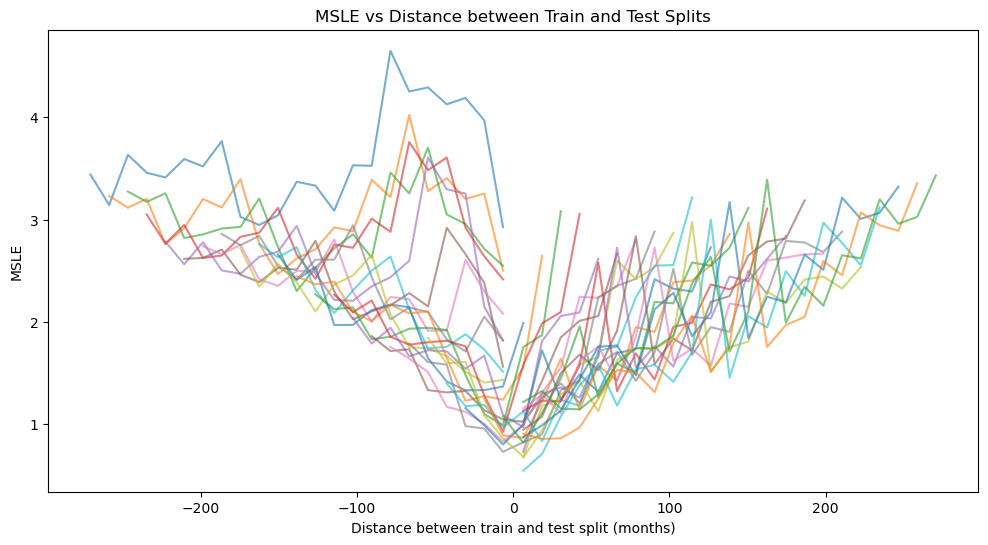

In [70]:
# plot mse and msle against distance, grouped by test_start
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for test_start, group in metrics_df.groupby("test_start"):
    plt.plot(group["distance"], group["msle"], label=f"test_start={test_start}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("MSLE vs Distance between Train and Test Splits")
#plt.legend()
plt.show()

## Test with better dataset and more features

Read in joint_narrow dataset from VIEWSER

In [15]:
fat_data = pd.read_parquet("../data/raw/fatalities002_joint_narrow.parquet")
fat_data.reset_index(inplace=True,)

Define features and target (predict for log target this time)

In [16]:
fat_features = [
        'ln_ged_sb_dep', 'ln_ged_sb', 'reign_tenure_months',
       'wdi_sp_pop_totl', 'wdi_ag_lnd_frst_k2', 'wdi_nv_agr_totl_kn',
       'wdi_sh_sta_maln_zs', 'wdi_sl_tlf_totl_fe_zs', 'wdi_sm_pop_refg_or',
       'wdi_sp_dyn_imrt_in', 'wdi_sp_pop_14_fe_zs', 'wdi_sp_pop_grow',
       'vdem_v2xcl_dmove', 'vdem_v2xcl_rol', 'vdem_v2xeg_eqdr',
       'vdem_v2xpe_exlpol', 'vdem_v2xpe_exlsocgr', 'ln_ged_sb_tlag_1',
       'ln_ged_sb_tlag_2', 'splag_wdi_ag_lnd_frst_k2',
       'splag_wdi_sl_tlf_totl_fe_zs', 'splag_wdi_sm_pop_netm',
       'splag_vdem_v2xpe_exlsocgr', 'splag_vdem_v2xcl_rol', 'decay_ged_sb_5',
       'decay_ged_os_5', 'decay_acled_os_5', 'decay_ged_sb_100',
       'decay_ged_sb_500', 'splag_1_decay_ged_sb_5'
]
fat_target = "ln_ged_sb"

And make new Dynamic model:

In [17]:
fat_model = DynamicModelManager(
    steps = [12],
    data = fat_data,
    features = fat_features,
    target = fat_target,
    train_window_size=120,
    test_window_size=12,
    slide_window_size = 12,
    full_split = (156, 540) #restrict to 1990-2024 to avoid excess zeroes
)

In [39]:
month_id_to_ym(156), month_id_to_ym(540)

('December 1992', 'December 2024')

Fit the models:

In [18]:
fat_model.fit()

Fitting models: 100%|██████████| 22/22 [05:59<00:00, 16.32s/it]

Finished fitting all models in 359.13 seconds


Predict:

In [19]:
fat_model.predict(data = fat_data)

Predicting: 100%|██████████| 462/462 [00:07<00:00, 61.07it/s]


Define actuals and calculate metrics:

In [20]:
actuals = fat_data[["country_id", "month_id", "ln_ged_sb"]]

In [21]:
rows = []

for prediction in fat_model.predictions:
    row = {
        "train_start": prediction.train_split.start_month,
        "train_end": prediction.train_split.end_month,
        "train_step": prediction.train_split.step,
        "test_start": prediction.test_split.start_month,
        "test_end": prediction.test_split.end_month,
        "test_step": prediction.test_split.step,
        "mse": prediction.mse(actuals),
        "msle": prediction.msle(actuals),
        "distance": prediction.distance_
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

Plot msle against distance:

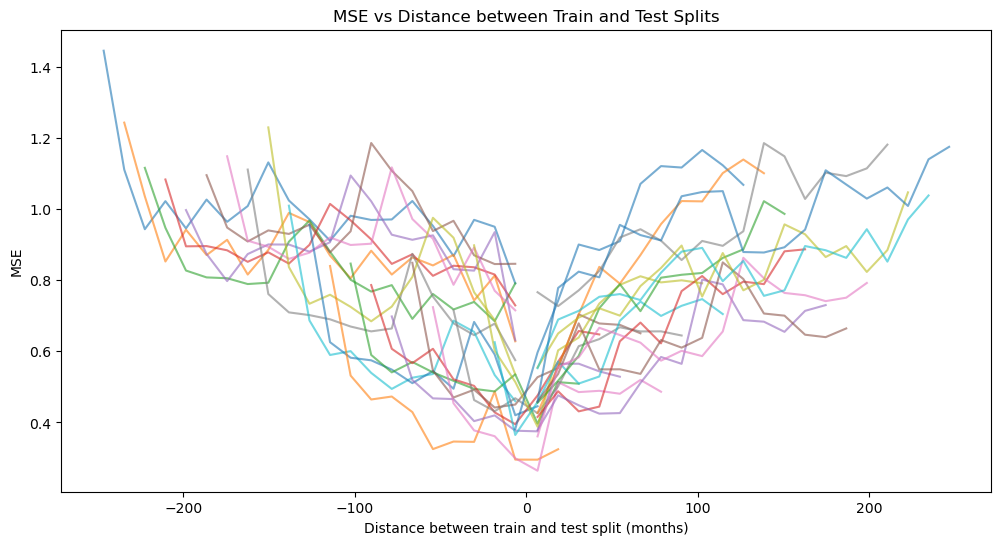

In [29]:
# plot mse and msle against distance, grouped by test_start
metrics = metrics_df.copy()

step = 12
start = 325
plt.figure(figsize=(12, 6))
for (test_start, test_step), group in metrics.groupby(["test_start", "test_step"]):
        plt.plot(group["distance"], group["mse"], label=f"test_start={test_start}, test_step={test_step}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSE")
plt.title("MSE vs Distance between Train and Test Splits")
#plt.legend()
plt.savefig("../figs/mse_distance_plot.png")
plt.show()

And make aggregated version of the plot with mean and standard deviation of MSLE for each distance:

In [41]:
# compute mean and std of mse by distance
mean_mse = metrics_df.groupby("distance")["mse"].mean()
std_mse = metrics_df.groupby("distance")["mse"].std()

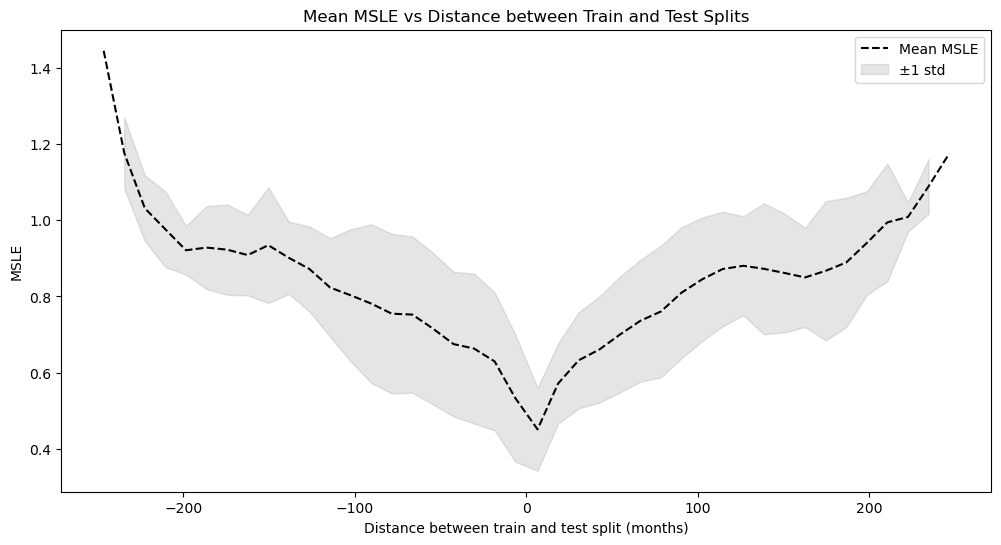

In [42]:
# plot mean mse and std of mse against distance
plt.figure(figsize=(12, 6))
plt.plot(mean_mse.index, mean_mse.values, label="Mean MSLE", color="black", linestyle ="--")
plt.fill_between(mean_mse.index, mean_mse.values - std_mse.values, mean_mse.values + std_mse.values, alpha=0.2, color="gray", label="±1 std")
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("Mean MSLE vs Distance between Train and Test Splits")
plt.legend()
plt.savefig("../figs/msle_distance_plot_future_agg.png")
plt.show()

Make same plots but only for test sets into the future:

In [43]:
metri = metrics_df[metrics_df["distance"] > 0]

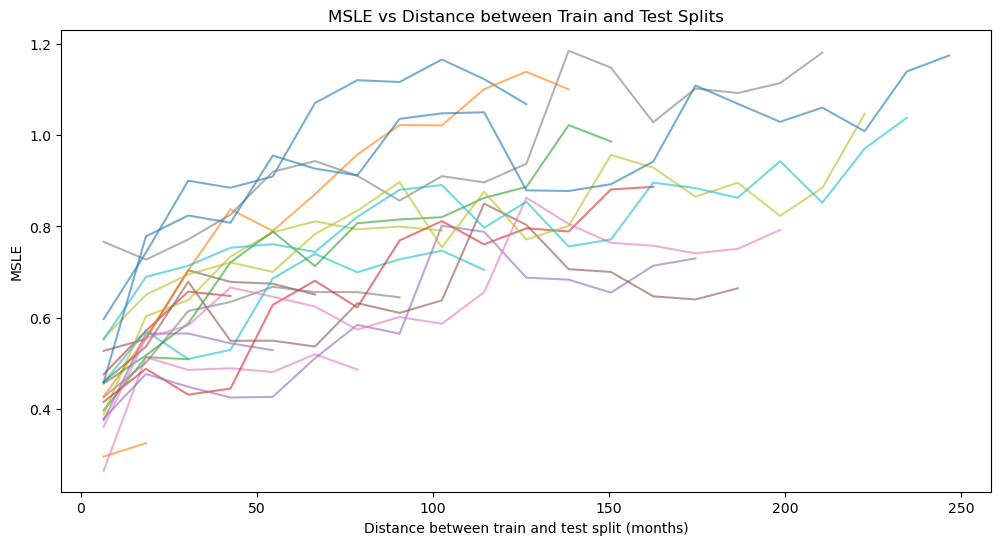

In [44]:
plt.figure(figsize=(12, 6))
for (test_start, test_step), group in metri.groupby(["test_start", "test_step"]):
        plt.plot(group["distance"], group["mse"], label=f"test_start={test_start}, test_step={test_step}", alpha=0.6)
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("MSLE vs Distance between Train and Test Splits")
#plt.legend()
plt.savefig("../figs/msle_distance_plot_future.png")
plt.show()

In [45]:
# compute mean and std of mse by distance
mean_mse = metri.groupby("distance")["mse"].mean()
std_mse = metri.groupby("distance")["mse"].std()

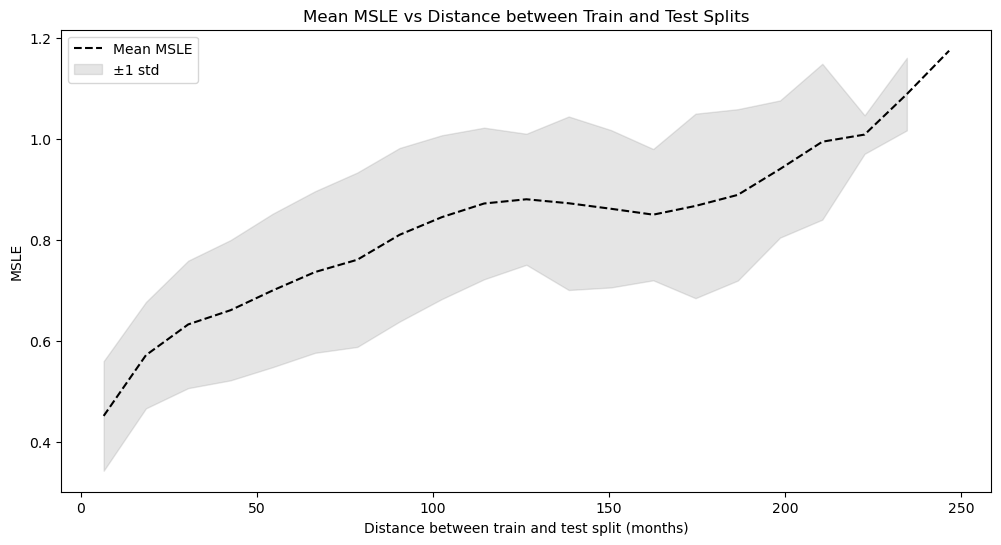

In [46]:
# plot mean mse and std of mse against distance
plt.figure(figsize=(12, 6))
plt.plot(mean_mse.index, mean_mse.values, label="Mean MSLE", color="black", linestyle ="--")
plt.fill_between(mean_mse.index, mean_mse.values - std_mse.values, mean_mse.values + std_mse.values, alpha=0.2, color="gray", label="±1 std")
plt.xlabel("Distance between train and test split (months)")
plt.ylabel("MSLE")
plt.title("Mean MSLE vs Distance between Train and Test Splits")
plt.legend()
plt.savefig("../figs/msle_distance_plot_future_agg.png")
plt.show()

## Bonus: vizualise train-test splits and predictions

In [33]:
def plot_all_train_test_layout(manager: DynamicModelManager, save_path: str = "../figs/", save: bool = False):

    train_splits = manager.get_train_splits()
    test_splits = manager.get_test_splits()

    month_min, month_max = manager.full_split
    months = np.arange(month_min, month_max + 1)

    # Matrix: rows = train splits, columns = months
    layout = np.zeros((len(train_splits), len(months)))

    for i, train_split in enumerate(train_splits):

        for test_split in test_splits:

            # Only compare same step
            if test_split.step != train_split.step:
                continue

            if not manager._has_overlap(train_split, test_split):

                # mark test months as 1
                mask = (months >= test_split.start_month) & (months <= test_split.end_month)
                layout[i, mask] = 1

        # mark train months as 2 (optional highlight)
        train_mask = (months >= train_split.start_month) & (months <= train_split.end_month)
        layout[i, train_mask] = 2

    df = pd.DataFrame(layout, columns=months)

    plt.figure(figsize=(18, 10))

    cmap = ListedColormap(["grey", "lightblue", "maroon"])

    sns.heatmap(df, cmap=cmap, cbar=False)

    plt.xlabel("Month ID")
    plt.ylabel("Train Split Index")

    # add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='grey', label='No Data'),
        Patch(facecolor='lightblue', label='Test'),
        Patch(facecolor='maroon', label='Train')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Train/Test Split Structure Across All Models")
    plt.savefig(save_path + "train_test_layout.png")
    plt.show()

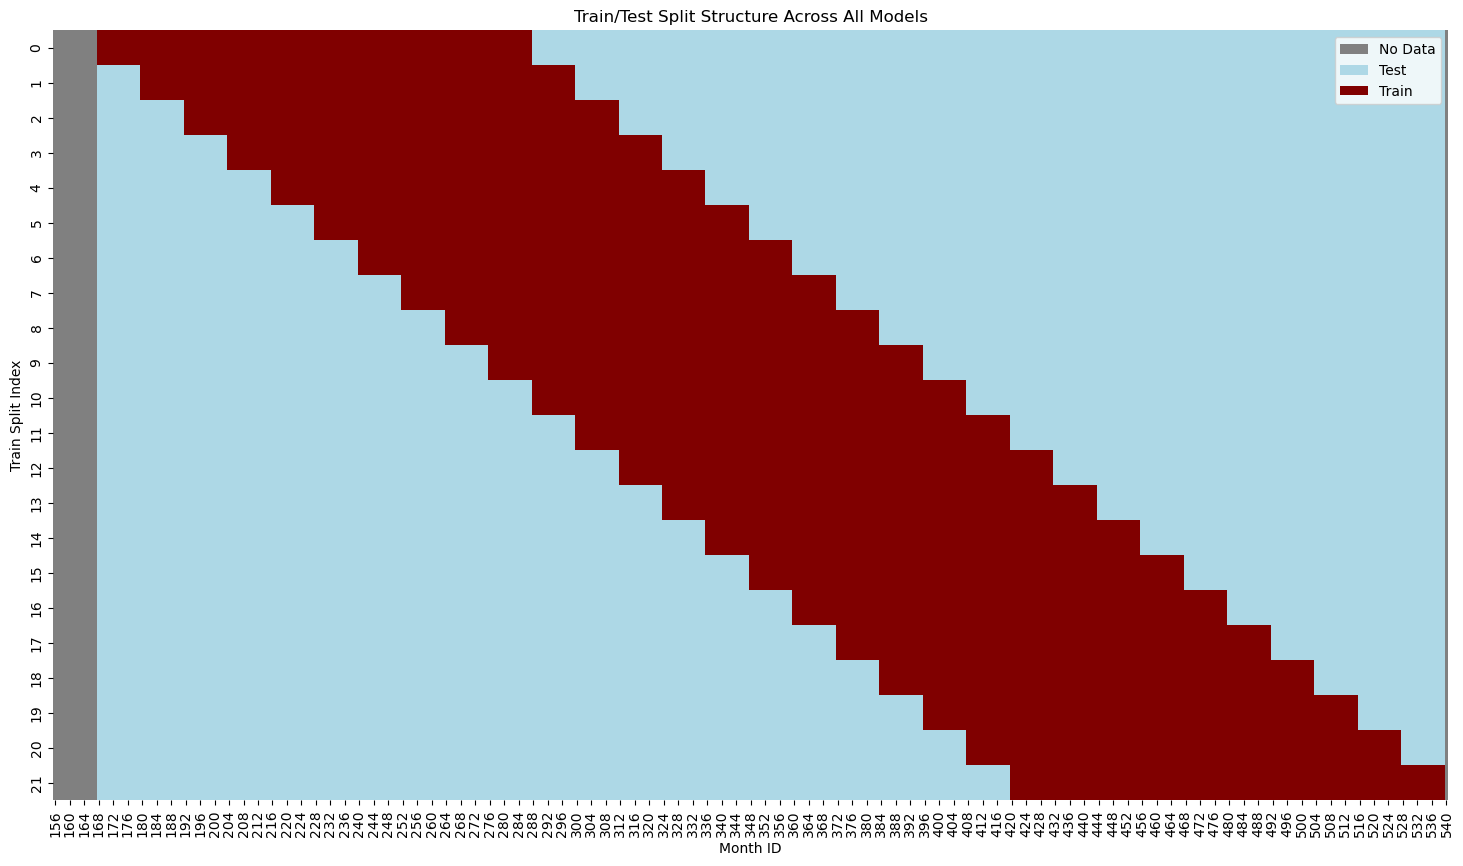

In [34]:
plot_all_train_test_layout(fat_model, save = True)